# Learnable activation functions
**Name**: Enikő Palencsár \
**Neptune**: YD11NL \
**Course**: Geometric modelling and applications \
**Description**: Implement simple neural networks with different learnable activation functions, chosen from the approximation and interpolation curves we learnt about in class. Observe their performance, strengths, weaknesses.

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torchinfo import summary
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import time
import copy 
import random
from pathlib import Path

In [4]:
SEED = 22
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

## General function for training loop

In [5]:
def train_model(model, x_train, y_train, optimizer, loss_fn, epochs: int = 1000, info_frequency: int = 50):
    """Training loop for PyTorch model
    
    Arguments: model, training features, expected output features, optimizer, 
    loss function, number of epoch to run, number of epochs on which loss info should be printed.
    Returns list of training loss values per epoch.
    """
    assert(epochs > 0 and info_frequency > 0), "Epoch number and info frequency must be positive."
    losses = []
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(x_train)
        loss = loss_fn(output, y_train)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    
        # Print loss occasionally
        if (epoch + 1) % info_frequency == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")
    return losses

In [6]:
def train_model_with_validation(
    model, 
    x_train, y_train,
    x_val, y_val,
    optimizer, 
    loss_fn, 
    epochs: int = 1000, 
    info_frequency: int = 50, 
    patience: int = 10
):
    """Training loop for PyTorch model with validation
    
    Arguments: model, training features, expected output features, validation features and expected validation outputs, optimizer, 
    loss function, number of epoch to run, number of epochs on which loss info should be printed, patience (epochs) for early stopping.
    Returns list of training loss values, list of validation loss values per epoch and total execution time.
    """
    assert(epochs > 0 and info_frequency > 0 and patience > 0), "Epoch number, info frequency and patience must be positive."
    
    start_time = time.time()
    train_losses = []
    val_losses = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = float('inf')
    epochs_no_improve = 0
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(x_train)
        loss = loss_fn(output, y_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        #Validation
        model.eval()
        with torch.no_grad():
            val_output = model(x_val)
            val_loss = loss_fn(val_output, y_val)
            val_losses.append(val_loss.item())
    
        # Print loss occasionally
        if (epoch + 1) % info_frequency == 0:
            print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {loss.item():.4f} - Val Loss: {val_loss.item():.4f}")

        #Early stopping check
        if val_loss.item() < best_val_loss - 1e-6:
            best_val_loss = val_loss.item()
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break
    model.load_state_dict(best_model_wts)
    duration = time.time() - start_time
    print(f"Training completed in {duration:.2f} seconds. Best Val Loss: {best_val_loss:.4f}")
    return train_losses, val_losses, duration

## General function for model evaluation

In [7]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_model(model, X_test_tensor, y_test_tensor):
    # Set the model to evaluation mode (disables dropout, batch normalization, etc.)
    model.eval()

    # Disable gradient calculation for inference (saves memory and computation)
    with torch.no_grad():
        y_pred_tensor = model(X_test_tensor)
        
        y_pred = y_pred_tensor.numpy()
        y_true = y_test_tensor.numpy()
        
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)

        # Print metrics
        print(f"Mean Absolute Error (MAE): {mae:.4f}")
        print(f"Mean Squared Error (MSE): {mse:.4f}")
        print(f"R² Score: {r2:.4f}")
        
        # Visualizing the predictions vs actual values
        plt.figure(figsize=(12, 6))

        # Plotting the predictions vs actual values
        plt.subplot(1, 2, 1)
        plt.scatter(y_true, y_pred, alpha=0.5)
        plt.plot([0, 1], [0, 1], '--r', label="Perfect Prediction")  # Line for perfect prediction
        plt.title("Predictions vs Actual")
        plt.xlabel("Actual Values")
        plt.ylabel("Predicted Values")
        plt.legend()

        # Visualizing the distribution of predictions
        plt.subplot(1, 2, 2)
        plt.hist(y_pred, bins=30, alpha=0.7, color='blue', label="Predictions")
        plt.hist(y_true, bins=30, alpha=0.7, color='red', label="Actual Values")
        plt.title("Distribution of Predictions vs Actual")
        plt.xlabel("Chance of Admit")
        plt.ylabel("Frequency")
        plt.legend()

        plt.tight_layout()
        plt.show()

    return mae, mse, r2

## General functions for loss and activation function visualization

In [8]:
def visualize_activation(title, activation, x_train, y_train = None):
    with torch.no_grad():
        y = activation(x_train)
    
    plt.figure(figsize=(8, 4))
    
    # Plot the learned activation function
    plt.plot(x_train.numpy(), y.numpy(), label='Learned activation function', color='blue')
    
    # Plot the training data points
    if y_train is not None:
        plt.plot(x_train.numpy(), y_train.numpy(), label='Training data', color='green')
    
    plt.title(title)
    plt.xlabel('Input')
    plt.ylabel('Output')
    plt.grid(True)
    plt.legend()
    plt.show()

In [9]:
def visualize_loss(title, losses, val_losses = None ):
    plt.figure(figsize=(12, 5))
    plt.plot(losses, label='Training loss')
    if val_losses:
        plt.plot(val_losses, label='Validation loss')   
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(title)
    plt.show()

## Class for a B-spline activation layer
With separately parametrised curves on every neuron

In [10]:
class BSplineActivationLayer(nn.Module):
    def __init__(self, num_neurons: int, degree: int, control_point_num: int):
        super(BSplineActivationLayer, self).__init__()
        self.num_neurons = num_neurons
        self.degree = degree
        self.control_point_num = control_point_num

        # Each neuron has its own learnable control points
        self.control_points = nn.Parameter(torch.randn(num_neurons, control_point_num))
        # Shared knot vector (uniform)
        knots = torch.linspace(0, 1, control_point_num + degree + 1)
        self.register_buffer('knots', knots)

    def forward(self, x):
        batch_size = x.shape[0]

        # Scale input to valid knot range
        x_min = x.min(dim=0, keepdim=True)[0]
        x_max = x.max(dim=0, keepdim=True)[0]
        x_scaled = self._scale_to_interval(x, self.knots[self.degree], self.knots[-self.degree-1], x_min, x_max)
        # Shape: (batch_size, num_neurons)

        # Compute B-spline basis functions for each neuron
        # Output: (batch_size, num_neurons, control_point_num)
        basis = self._compute_basis_functions(x_scaled)

        # control_points: (num_neurons, control_point_num)
        # basis: (batch_size, num_neurons, control_point_num)
        # --> need to perform weighted sum over control_point_num dimension
        result = torch.sum(basis * self.control_points.unsqueeze(0), dim=2)

        return result  # shape: (batch_size, num_neurons)

    def _scale_to_interval(self, x, min_val, max_val, x_min, x_max):
        return min_val + (x - x_min) * (max_val - min_val) / (x_max - x_min + 1e-8)

    def _compute_basis_functions(self, x):
        b = self._basis_function(x, self.degree)
        return b

    def _basis_function(self, x, k):
        batch_size, num_neurons = x.shape
        cp = self.control_point_num

        # Initialize 0-degree basis
        basis = []
        for i in range(cp):
            left = self.knots[i]
            right = self.knots[i + 1]
            basis_i = ((x >= left) & (x < right)).float()
            basis.append(basis_i.unsqueeze(-1))  # (batch_size, num_neurons, 1)
        basis = torch.cat(basis, dim=2)  # (batch_size, num_neurons, control_point_num)

        # Recursively compute higher-degree bases
        for d in range(1, k):
            new_basis = []
            for i in range(cp):
                denom1 = self.knots[i + d] - self.knots[i]
                denom2 = self.knots[i + d + 1] - self.knots[i + 1]

                coeff1 = (x - self.knots[i]) / (denom1 + 1e-8)
                coeff2 = (self.knots[i + d + 1] - x) / (denom2 + 1e-8)

                term1 = coeff1 * basis[:, :, i] if denom1 > 0 else 0.0
                term2 = coeff2 * basis[:, :, i + 1] if i + 1 < cp and denom2 > 0 else 0.0

                new_basis.append((term1 + term2).unsqueeze(-1))
            basis = torch.cat(new_basis, dim=2)
        return basis  # shape: (batch_size, num_neurons, control_point_num)


## Class for a NURBS activation layer
With separately parametrised curves on every neuron

In [11]:
class NURBSActivationLayer(nn.Module):
    def __init__(self, num_neurons: int, degree: int, control_point_num: int):
        super(NURBSActivationLayer, self).__init__()
        self.num_neurons = num_neurons
        self.degree = degree
        self.control_point_num = control_point_num

        # Each neuron gets its own control points and weights
        self.control_points = nn.Parameter(torch.randn(num_neurons, control_point_num))
        self.weights = nn.Parameter(torch.ones(num_neurons, control_point_num))

        # Shared uniform knot vector
        knots = torch.linspace(0, 1, control_point_num + degree + 1)
        self.register_buffer('knots', knots)

    def forward(self, x):
        batch_size = x.size(0)

        # Scale input for each neuron
        x_min = x.min(dim=0, keepdim=True)[0]
        x_max = x.max(dim=0, keepdim=True)[0]
        x_scaled = self._scale_to_interval(x, self.knots[self.degree], self.knots[-self.degree-1], x_min, x_max)
        # Shape: (batch_size, num_neurons)

        # Compute NURBS basis: (batch_size, num_neurons, control_point_num)
        basis = self._compute_basis_functions(x_scaled)

        # Numerator: ∑ R_i(x) * P_i
        weighted_basis = basis * self.weights.unsqueeze(0)  # (batch_size, num_neurons, cp)
        numerator = weighted_basis * self.control_points.unsqueeze(0)  # elementwise

        # Sum over control points
        num = torch.sum(numerator, dim=2)  # (batch_size, num_neurons)
        denom = torch.sum(weighted_basis, dim=2) + 1e-6  # (batch_size, num_neurons)
        return num / denom  # (batch_size, num_neurons)

    def _scale_to_interval(self, x, min_val, max_val, x_min, x_max):
        return min_val + (x - x_min) * (max_val - min_val) / (x_max - x_min + 1e-8)

    def _compute_basis_functions(self, x):
        return self._basis_function(x, self.degree)

    def _basis_function(self, x, k):
        batch_size, num_neurons = x.shape
        cp = self.control_point_num

        # Initialize degree-0 basis
        basis = []
        for i in range(cp):
            left = self.knots[i]
            right = self.knots[i + 1]
            b = ((x >= left) & (x < right)).float()
            basis.append(b.unsqueeze(-1))  # (batch_size, num_neurons, 1)
        basis = torch.cat(basis, dim=2)  # (batch_size, num_neurons, cp)

        for d in range(1, k):
            new_basis = []
            for i in range(cp):
                denom1 = self.knots[i + d] - self.knots[i]
                denom2 = self.knots[i + d + 1] - self.knots[i + 1]

                coeff1 = (x - self.knots[i]) / (denom1 + 1e-8)
                coeff2 = (self.knots[i + d + 1] - x) / (denom2 + 1e-8)

                term1 = coeff1 * basis[:, :, i] if denom1 > 0 else 0.0
                term2 = coeff2 * basis[:, :, i + 1] if i + 1 < cp and denom2 > 0 else 0.0

                new_basis.append((term1 + term2).unsqueeze(-1))
            basis = torch.cat(new_basis, dim=2)

        return basis  # (batch_size, num_neurons, control_point_num)


## Class for Lagrange activation layer
With separately parametrised curves on every neuron

In [12]:
class LagrangeActivationLayer(nn.Module):
    def __init__(self, num_neurons: int, degree: int):
        super(LagrangeActivationLayer, self).__init__()
        self.num_neurons = num_neurons
        self.degree = degree
        self.n_points = degree + 1

        # Each neuron gets its own interpolation values (learnable)
        self.interpolation_points = nn.Parameter(torch.randn(num_neurons, self.n_points))

        # Fixed u_values in [-1, 1] for all neurons (same x support)
        self.register_buffer('u_values', torch.linspace(-1, 1, self.n_points))  # (n_points,)

        # Precompute Lagrange denominator terms
        self.register_buffer('denominator', self._compute_denominators())

    def forward(self, x):
        batch_size, num_neurons = x.shape
        assert num_neurons == self.num_neurons, "Mismatch in neuron count."

        # Scale x to match the interpolation interval [-1, 1]
        x_min = x.min(dim=0, keepdim=True)[0]
        x_max = x.max(dim=0, keepdim=True)[0]
        x_scaled = -1 + 2 * (x - x_min) / (x_max - x_min + 1e-8)  # (batch_size, num_neurons)

        # Evaluate Lagrange basis polynomials (batch_size, num_neurons, n_points)
        lagrange_vals = self._evaluate_lagrange_basis(x_scaled)

        # Weighted sum over interpolation points
        output = torch.sum(lagrange_vals * self.interpolation_points.unsqueeze(0), dim=2)
        return output  # (batch_size, num_neurons)

    def _compute_denominators(self):
        u = self.u_values  # (n_points,)
        diff = u.unsqueeze(0) - u.unsqueeze(1)  # (n_points, n_points)
        diff.fill_diagonal_(1.0)
        denom = torch.prod(diff, dim=1)  # (n_points,)
        return denom  # (n_points,)

    def _evaluate_lagrange_basis(self, x):
        bsz, neurons = x.shape
        n_points = self.n_points

        # Expand x to shape (batch_size, num_neurons, n_points)
        x_exp = x.unsqueeze(-1)  # (bsz, neurons, 1)
        u = self.u_values.view(1, 1, n_points)  # (1, 1, n_points)
        numerators = []

        for i in range(n_points):
            mask = torch.ones(n_points, dtype=torch.bool, device=x.device)
            mask[i] = False
            u_j = u[..., mask]  # (1, 1, n_points - 1)
            terms = x_exp - u_j  # (bsz, neurons, n_points - 1)
            prod = torch.prod(terms, dim=-1)  # (bsz, neurons)
            numerators.append(prod / self.denominator[i])  # Normalize

        basis = torch.stack(numerators, dim=-1)  # (bsz, neurons, n_points)
        return basis


# Experiments

## Graduate admissions dataset

In [2]:
file_path = Path("data") / "Admission_Predict_Ver1.1.csv"
df = pd.read_csv(file_path)
df.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


We do not need the serial numbers, drop them.

In [128]:
df_short = df.drop(['Serial No.'], axis=1)

Check for empty values

In [129]:
df_short.isnull().sum()

GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Chance of Admit      0
dtype: int64

In [130]:
df_short.shape

(500, 8)

### Plot distributions by feature

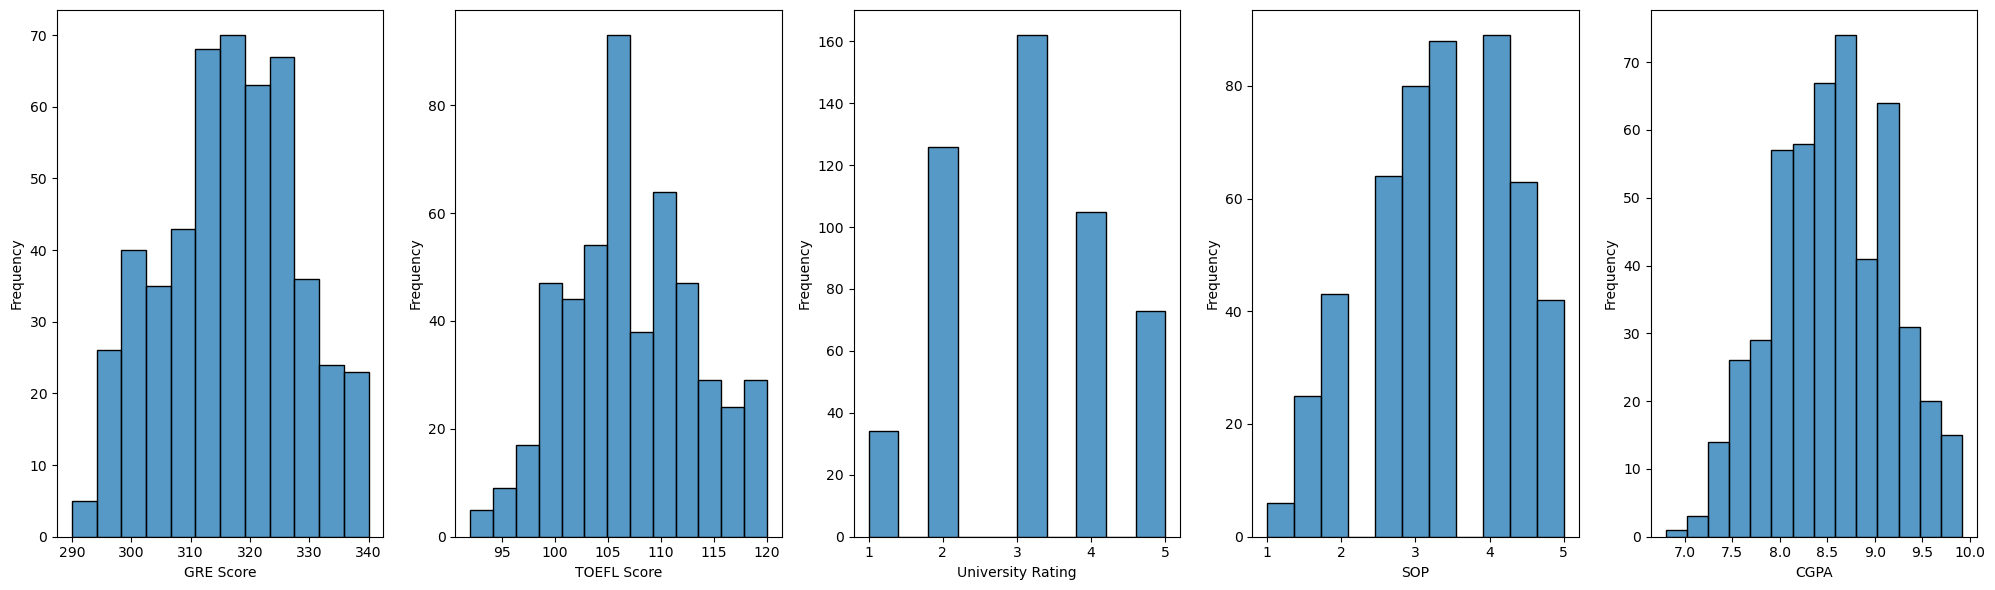

In [131]:
# Define the features to plot
features = ['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'CGPA']

# Create a figure and axes for the subplots
fig, axes = plt.subplots(1, 5, figsize=(20, 6))

for i, feature in enumerate(features):
    sns.histplot(df_short[feature], ax=axes[i])
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

# Adjust layout for better spacing between plots
plt.tight_layout()
plt.show()

### Prepare data for processing

In [132]:
X = df_short.drop(columns=['Chance of Admit '])
y = df_short['Chance of Admit ']
X.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research
0,337,118,4,4.5,4.5,9.65,1
1,324,107,4,4.0,4.5,8.87,1
2,316,104,3,3.0,3.5,8.00,1
3,322,110,3,3.5,2.5,8.67,1
4,314,103,2,2.0,3.0,8.21,0


In [133]:
y.head()

0    0.92
1    0.76
2    0.72
3    0.80
4    0.65
Name: Chance of Admit , dtype: float64

#### Create train, validation and test sets

In [134]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1, random_state=42)
X_train.shape, X_val.shape, X_test.shape

((360, 7), (40, 7), (100, 7))

#### Scale values

In [135]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [136]:
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

### Construct and train NN with ReLU activation

In [137]:
class ReluNN(nn.Module):
    def __init__(self, input_size):
        super(ReluNN, self).__init__()
        self.linear1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(64, 32)
        self.linear3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear3(x)
        # Result between 0 and 1
        x = self.sigmoid(x)
        return x

In [138]:
input_size = X_train_tensor.shape[1]  # Number of features
relu_model = ReluNN(input_size)

In [139]:
summary(relu_model, input_size=X_train_tensor.shape)

Layer (type:depth-idx)                   Output Shape              Param #
ReluNN                                   [360, 1]                  --
├─Linear: 1-1                            [360, 64]                 512
├─ReLU: 1-2                              [360, 64]                 --
├─Dropout: 1-3                           [360, 64]                 --
├─Linear: 1-4                            [360, 32]                 2,080
├─ReLU: 1-5                              [360, 32]                 --
├─Dropout: 1-6                           [360, 32]                 --
├─Linear: 1-7                            [360, 1]                  33
├─Sigmoid: 1-8                           [360, 1]                  --
Total params: 2,625
Trainable params: 2,625
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.94
Input size (MB): 0.01
Forward/backward pass size (MB): 0.28
Params size (MB): 0.01
Estimated Total Size (MB): 0.30

In [140]:
# Optimizer
optimizer = optim.Adam(relu_model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

train_losses, val_losses, exec_time = train_model_with_validation(
    relu_model, 
    X_train_tensor, y_train_tensor,
    X_val_tensor, y_val_tensor,
    optimizer, loss_fn, 
    epochs = 1000, info_frequency = 50, patience = 50)

Epoch [50/1000] - Train Loss: 0.0065 - Val Loss: 0.0031
Epoch [100/1000] - Train Loss: 0.0046 - Val Loss: 0.0025
Epoch [150/1000] - Train Loss: 0.0043 - Val Loss: 0.0024
Early stopping triggered at epoch 168
Training completed in 0.68 seconds. Best Val Loss: 0.0024


### Plot loss curve

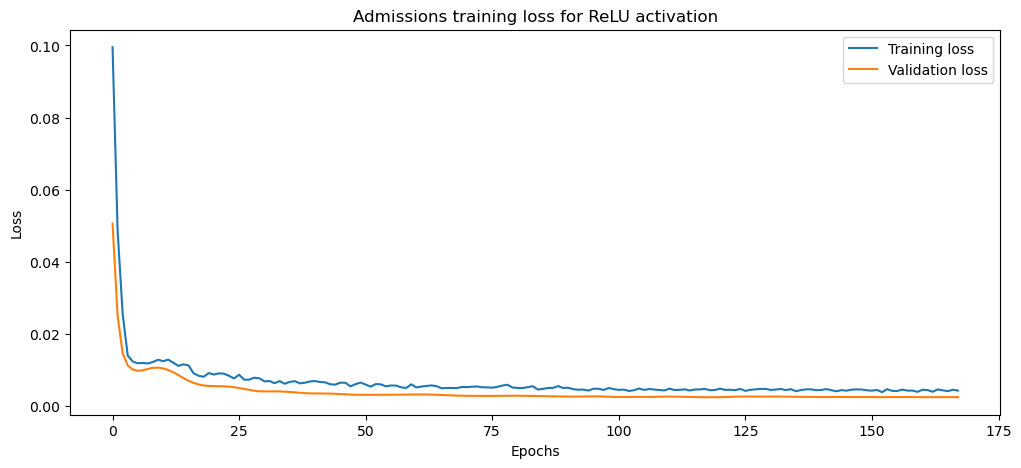

In [141]:
visualize_loss("Admissions training loss for ReLU activation", train_losses, val_losses)

### Evaluate model on test set

Mean Absolute Error (MAE): 0.0453
Mean Squared Error (MSE): 0.0042
R² Score: 0.7924


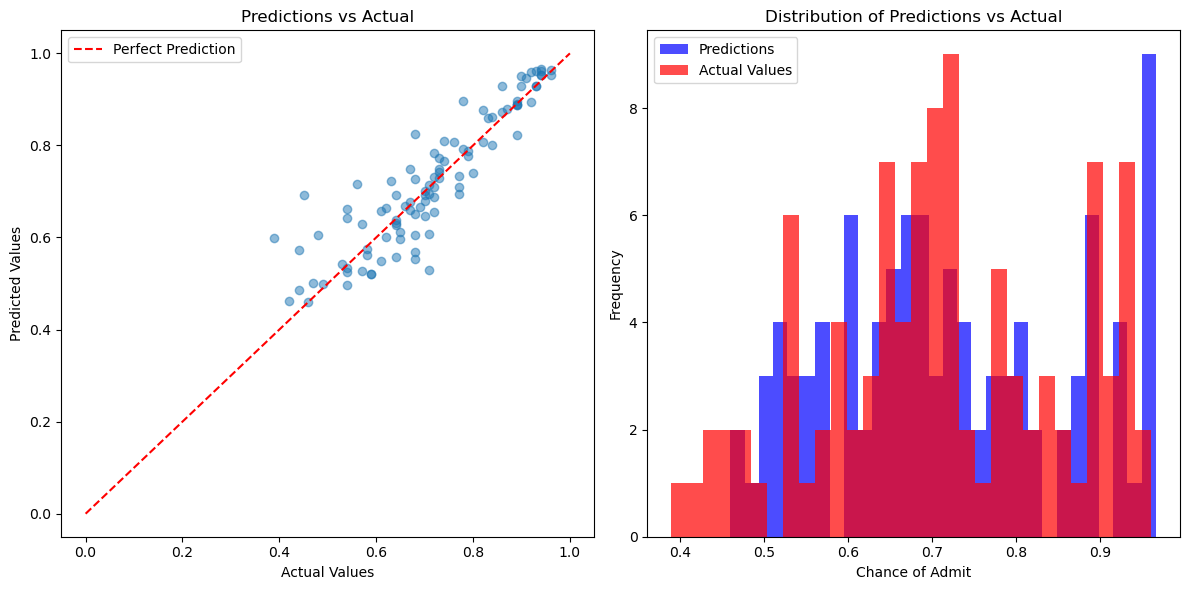

In [142]:
mae, mse, r2 = evaluate_model(relu_model, X_test_tensor, y_test_tensor)

## Make summary dataframe

In [143]:
model_results = pd.DataFrame(columns=[
    'model_type',
    'train_time',
    'test_mse',
    'test_mae',
    'test_r2',
    'epochs'
])

In [144]:
new_row = pd.DataFrame([{
    'model_type': 'ReLU',
    'train_time': exec_time,
    'test_mse': mse,
    'test_mae': mae,
    'test_r2': r2,
    'epochs': len(val_losses)
}])

model_results = pd.concat([model_results, new_row], ignore_index=True)

C:\Users\encip\AppData\Local\Temp\ipykernel_3552\2422367158.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_results = pd.concat([model_results, new_row], ignore_index=True)


In [145]:
model_results

,model_type,train_time,test_mse,test_mae,test_r2,epochs
0,ReLU,0.680423,0.004246,0.0453,0.792373,168


## Construct and train model with B-spline activation

In [146]:
class BsplineNN(nn.Module):
    def __init__(self, input_size, degree, control_point_num):
        super(BsplineNN, self).__init__()
        self.linear1 = nn.Linear(input_size, 64)
        self.bspline1 = BSplineActivationLayer(64, degree = degree, control_point_num = control_point_num)
        self.linear2 = nn.Linear(64, 32)
        self.bspline2 = BSplineActivationLayer(32, degree = degree, control_point_num = control_point_num)
        self.dropout = nn.Dropout(0.4)
        self.linear3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.linear1(x)
        x = self.bspline1(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.bspline2(x)
        x = self.dropout(x)
        x = self.linear3(x)
        # To get probability between 0 and 1
        x = self.sigmoid(x)
        return x

In [147]:
input_size = X_train_tensor.shape[1]
bspline_model = BsplineNN(input_size, degree = 3, control_point_num = 10)

In [148]:
summary(bspline_model, input_size=X_train_tensor.shape)

Layer (type:depth-idx)                   Output Shape              Param #
BsplineNN                                [360, 1]                  --
├─Linear: 1-1                            [360, 64]                 512
├─BSplineActivationLayer: 1-2            [360, 64]                 640
├─Dropout: 1-3                           [360, 64]                 --
├─Linear: 1-4                            [360, 32]                 2,080
├─BSplineActivationLayer: 1-5            [360, 32]                 320
├─Dropout: 1-6                           [360, 32]                 --
├─Linear: 1-7                            [360, 1]                  33
├─Sigmoid: 1-8                           [360, 1]                  --
Total params: 3,585
Trainable params: 3,585
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.94
Input size (MB): 0.01
Forward/backward pass size (MB): 0.56
Params size (MB): 0.01
Estimated Total Size (MB): 0.58

In [149]:
# Optimizer
optimizer = optim.Adam(bspline_model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

train_losses, val_losses, exec_time = train_model_with_validation(
    bspline_model, 
    X_train_tensor, y_train_tensor,
    X_val_tensor, y_val_tensor,
    optimizer, loss_fn, 
    epochs = 1000, info_frequency = 50, patience = 50)

Epoch [50/1000] - Train Loss: 0.0081 - Val Loss: 0.0057
Epoch [100/1000] - Train Loss: 0.0053 - Val Loss: 0.0045
Early stopping triggered at epoch 135
Training completed in 7.58 seconds. Best Val Loss: 0.0043


### Loss curve

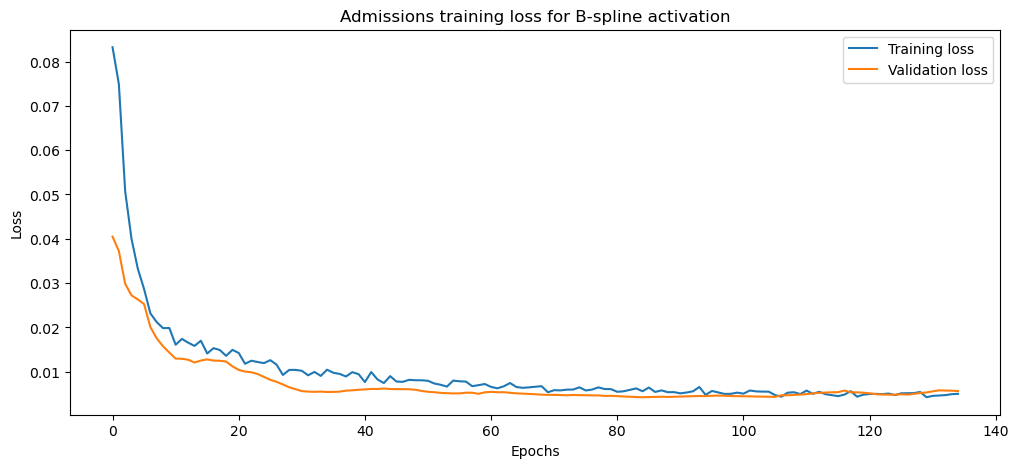

In [150]:
visualize_loss("Admissions training loss for B-spline activation", train_losses, val_losses)

### Evaluate

Mean Absolute Error (MAE): 0.0560
Mean Squared Error (MSE): 0.0054
R² Score: 0.7376


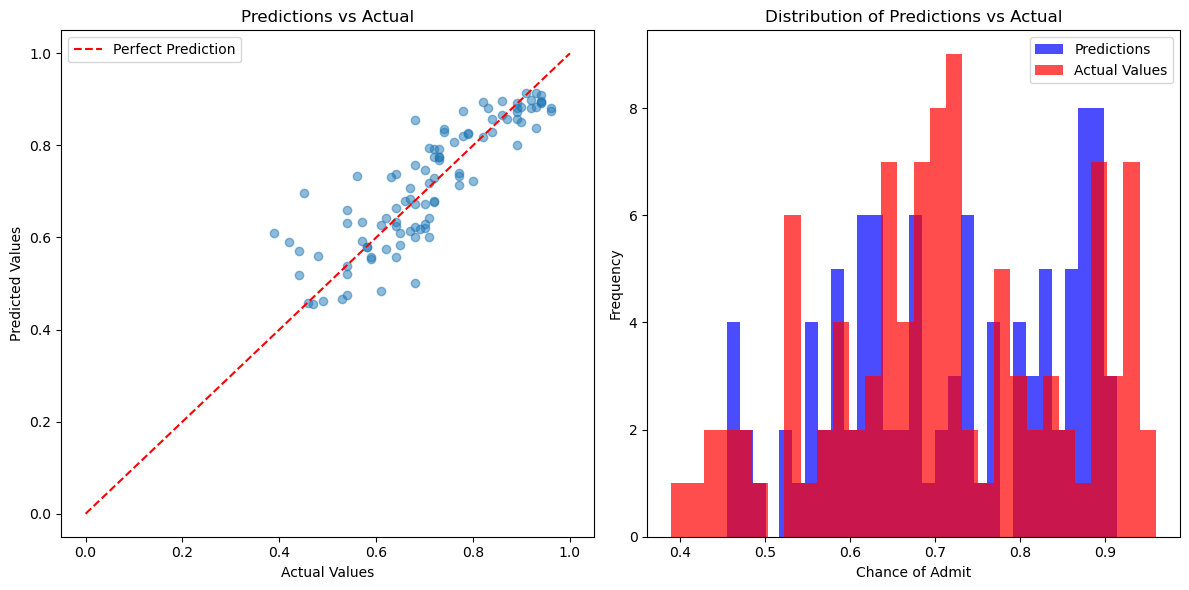

In [151]:
mae, mse, r2 = evaluate_model(bspline_model, X_test_tensor, y_test_tensor)

In [152]:
new_row = pd.DataFrame([{
    'model_type': 'B-spline',
    'train_time': exec_time,
    'test_mse': mse,
    'test_mae': mae,
    'test_r2': r2,
    'epochs': len(val_losses)
}])

model_results = pd.concat([model_results, new_row], ignore_index=True)

In [153]:
model_results

,model_type,train_time,test_mse,test_mae,test_r2,epochs
0,ReLU,0.680423,0.004246,0.045300,0.792373,168
1,B-spline,7.581138,0.005367,0.055986,0.737574,135


## Construct and train model with NURBS activation

In [154]:
class NURBSNN(nn.Module):
    def __init__(self, input_size, degree, control_point_num):
        super(NURBSNN, self).__init__()
        self.linear1 = nn.Linear(input_size, 64)
        self.nurbs1 = NURBSActivationLayer(64, degree = degree, control_point_num = control_point_num)
        self.linear2 = nn.Linear(64, 32)
        self.nurbs2 = NURBSActivationLayer(32, degree = degree, control_point_num = control_point_num)
        self.linear3 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.4)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.linear1(x)
        x = self.nurbs1(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.nurbs2(x)
        x = self.dropout(x)
        x = self.linear3(x)
        # To get probability between 0 and 1
        x = self.sigmoid(x)
        return x

In [155]:
input_size = X_train_tensor.shape[1]
nurbs_model = NURBSNN(input_size, degree = 3, control_point_num = 10)

In [156]:
summary(nurbs_model, input_size=X_train_tensor.shape)

Layer (type:depth-idx)                   Output Shape              Param #
NURBSNN                                  [360, 1]                  --
├─Linear: 1-1                            [360, 64]                 512
├─NURBSActivationLayer: 1-2              [360, 64]                 1,280
├─Dropout: 1-3                           [360, 64]                 --
├─Linear: 1-4                            [360, 32]                 2,080
├─NURBSActivationLayer: 1-5              [360, 32]                 640
├─Dropout: 1-6                           [360, 32]                 --
├─Linear: 1-7                            [360, 1]                  33
├─Sigmoid: 1-8                           [360, 1]                  --
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 19.38
Input size (MB): 0.01
Forward/backward pass size (MB): 0.56
Params size (MB): 0.02
Estimated Total Size (MB): 0.58

In [157]:
# Optimizer
optimizer = optim.Adam(nurbs_model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

train_losses, val_losses, exec_time = train_model_with_validation(
    nurbs_model, 
    X_train_tensor, y_train_tensor,
    X_val_tensor, y_val_tensor,
    optimizer, loss_fn, 
    epochs = 1000, info_frequency = 50, patience = 50)

Epoch [50/1000] - Train Loss: 0.0070 - Val Loss: 0.0055
Epoch [100/1000] - Train Loss: 0.0046 - Val Loss: 0.0056
Early stopping triggered at epoch 131
Training completed in 6.19 seconds. Best Val Loss: 0.0045


### Visualize loss

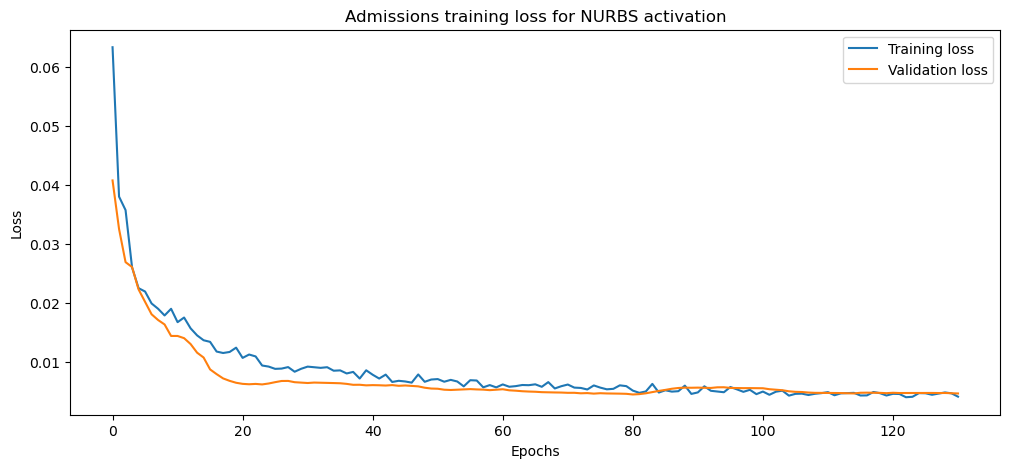

In [158]:
visualize_loss("Admissions training loss for NURBS activation", train_losses, val_losses)

### Evaluate model

Mean Absolute Error (MAE): 0.0532
Mean Squared Error (MSE): 0.0053
R² Score: 0.7432


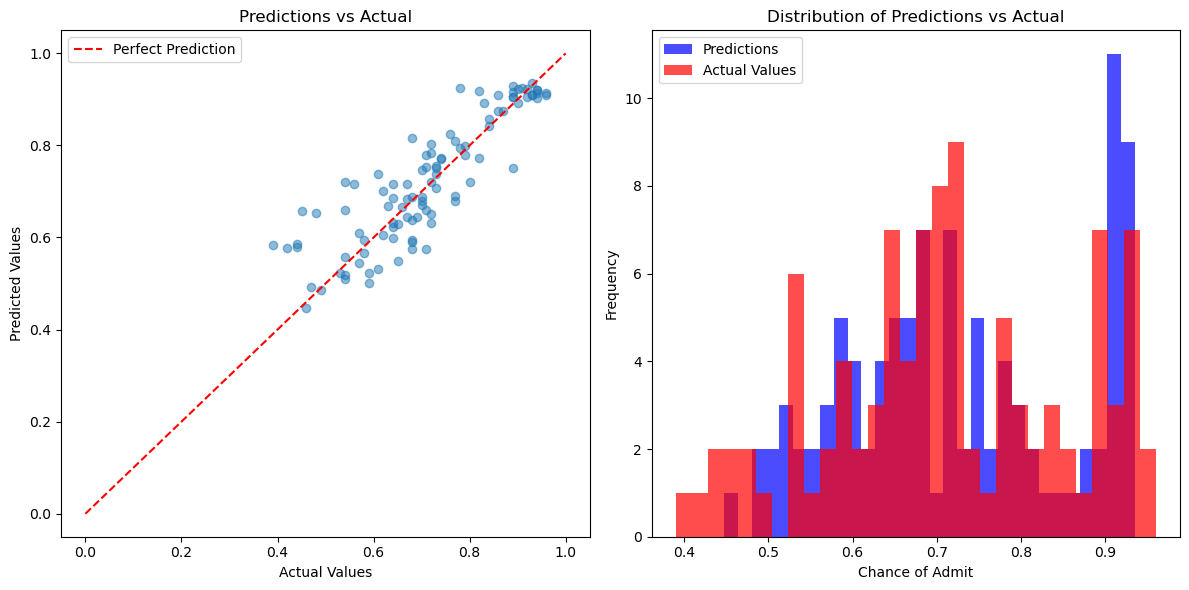

In [159]:
mae, mse, r2 = evaluate_model(nurbs_model, X_test_tensor, y_test_tensor)

In [160]:
new_row = pd.DataFrame([{
    'model_type': 'NURBS',
    'train_time': exec_time,
    'test_mse': mse,
    'test_mae': mae,
    'test_r2': r2,
    'epochs': len(val_losses)
}])

model_results = pd.concat([model_results, new_row], ignore_index=True)

In [161]:
model_results

,model_type,train_time,test_mse,test_mae,test_r2,epochs
0,ReLU,0.680423,0.004246,0.045300,0.792373,168
1,B-spline,7.581138,0.005367,0.055986,0.737574,135
2,NURBS,6.189730,0.005251,0.053236,0.743238,131


## Construct and train model with Lagrange activation

In [162]:
class LagrangeNN(nn.Module):
    def __init__(self, input_size, degree):
        super(LagrangeNN, self).__init__()
        self.linear1 = nn.Linear(input_size, 64)
        self.lagrange1 = LagrangeActivationLayer(64, degree = degree)
        self.sigmoid = nn.Sigmoid()
        self.linear2 = nn.Linear(64, 32)
        self.lagrange2 = LagrangeActivationLayer(32, degree = degree)
        self.dropout = nn.Dropout(0.4)
        self.linear3 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.lagrange1(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.lagrange2(x)
        x = self.dropout(x)
        x = self.linear3(x)
        # To get probability between 0 and 1
        x = self.sigmoid(x)
        return x

In [163]:
input_size = X_train_tensor.shape[1]
lagrange_model = LagrangeNN(input_size, degree = 13)

In [164]:
summary(lagrange_model, input_size = X_train_tensor.shape)

Layer (type:depth-idx)                   Output Shape              Param #
LagrangeNN                               [360, 1]                  --
├─Linear: 1-1                            [360, 64]                 512
├─LagrangeActivationLayer: 1-2           [360, 64]                 896
├─Dropout: 1-3                           [360, 64]                 --
├─Linear: 1-4                            [360, 32]                 2,080
├─LagrangeActivationLayer: 1-5           [360, 32]                 448
├─Dropout: 1-6                           [360, 32]                 --
├─Linear: 1-7                            [360, 1]                  33
├─Sigmoid: 1-8                           [360, 1]                  --
Total params: 3,969
Trainable params: 3,969
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.94
Input size (MB): 0.01
Forward/backward pass size (MB): 0.56
Params size (MB): 0.02
Estimated Total Size (MB): 0.58

In [165]:
# Optimizer
optimizer = optim.Adam(lagrange_model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

train_losses, val_losses, exec_time = train_model_with_validation(
    lagrange_model, 
    X_train_tensor, y_train_tensor,
    X_val_tensor, y_val_tensor,
    optimizer, loss_fn, 
    epochs = 1000, info_frequency = 50, patience = 50)

Epoch [50/1000] - Train Loss: 0.0291 - Val Loss: 0.0513
Epoch [100/1000] - Train Loss: 0.0218 - Val Loss: 0.0138
Early stopping triggered at epoch 149
Training completed in 12.06 seconds. Best Val Loss: 0.0126


### Visualize loss

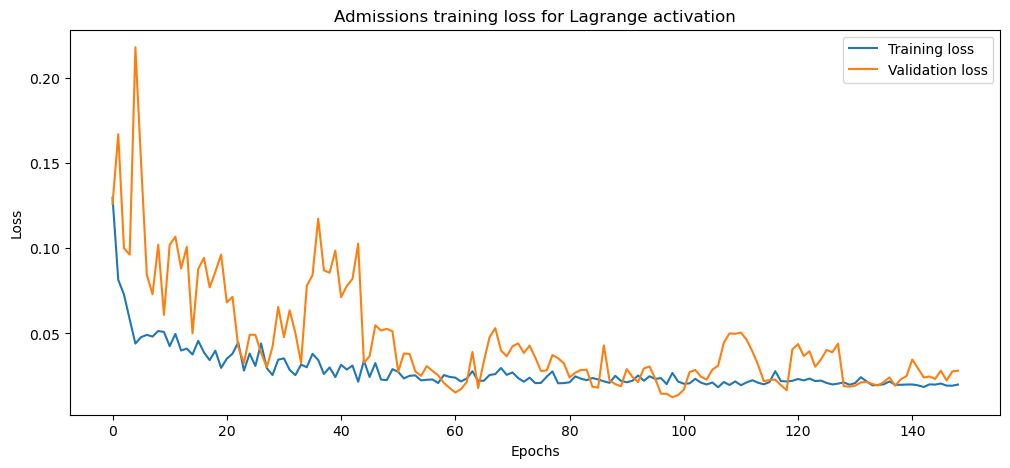

In [166]:
visualize_loss("Admissions training loss for Lagrange activation", train_losses, val_losses)

### Evaluate model

Mean Absolute Error (MAE): 0.1152
Mean Squared Error (MSE): 0.0203
R² Score: 0.0057


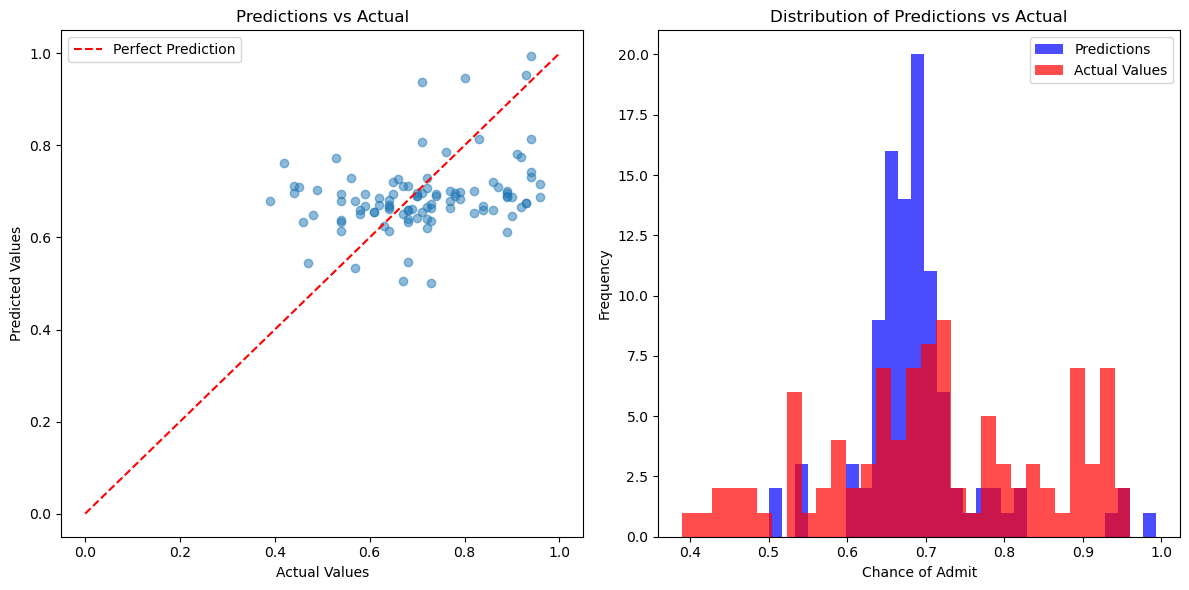

In [167]:
mae, mse, r2 = evaluate_model(lagrange_model, X_test_tensor, y_test_tensor)

In [168]:
new_row = pd.DataFrame([{
    'model_type': 'Lagrange',
    'train_time': exec_time,
    'test_mse': mse,
    'test_mae': mae,
    'test_r2': r2,
    'epochs': len(val_losses)
}])

model_results = pd.concat([model_results, new_row], ignore_index=True)

In [169]:
model_results

,model_type,train_time,test_mse,test_mae,test_r2,epochs
0,ReLU,0.680423,0.004246,0.045300,0.792373,168
1,B-spline,7.581138,0.005367,0.055986,0.737574,135
2,NURBS,6.189730,0.005251,0.053236,0.743238,131
3,Lagrange,12.055812,0.020333,0.115161,0.005720,149


### <span style="color: green;">Conclusions</span>
It is important to note that in the examples above, **model architectures** were constant, not parameter count.
- In the case of learnable activations parametrised per neuron instead of per layer, **overfitting** turned out to be a major issue.
  - In the original version, the B-spline version reached its best validation loss of about 0.01 around epoch 20, then proceeded to always overfit.
  - Therefore, dropout layers were introduced to help prevent overfitting - successfully.
- As expected, ReLU activations are by far the fastest (1 order of magnitude lower training times than for learnable activations)
- The usage of B-spline and NURBS activation functions resulted in similar training times, training epoch numbers and test losses.
- Lagrange activation functions produced the most unfavourable results: 3-4 times higher losses and 2-3 times higher training times.
  - Judging by the last distribution diagram and the $R^2$ value, the network mostly just predicts the sample mean in this case 
- The test MSE and MAE achieved is similar for ReLU, B-spline and NURBS activations.
- When using B-spline or NURBS activations, less epochs were needed to produce these results.
  - This suggests that the optimisation of these learnable activation layers might be advantageous even if we cannot reach the fast performance of a parameterless ReLU function. Less epochs means less backpropagation, which can prove to be a true benefit of these approximation curbe-based learnable activation functions.
- As evidenced by the loss diagrams, B-spline and NURBS activation functions provide standard train and validation loss convergence (slight oscillation of train loss possibly due to dropout layers - the per-layer-parametrised version did not present this variation). 
- When using Lagrange activation functions, the oscillation of validation loss is quite high at the beginning
  - However, contrary to the per-layer case, backpropagation seems to work here still, since the oscillation decreases as more and more epochs are completed and a convergence can be observed to the training loss. The variation still may exist due to the the implementation of the related Lagrange coefficient calculations.
- It is important to note that in the calculations above, **linear layer weights** were preserved and set to learnable not only in the case of ReLU but also when using learnable activation functions
  - In theory, the learnable curves could absorb the effect of weights, but maybe not in this NN configuration, as the elimination of weighted sums makes every input edge have the same "importance" in the curve calculations that follow.
  - For a network architecture that allows for the complete elimination of edge weights, see Kolmogorov-Arnold Networks

## Investigate the role of linear layer weights in NURBS NN

In [170]:
edge_weight_summary = pd.DataFrame(columns=[
    'model_type',
    'train_time',
    'test_mse',
    'test_mae',
    'test_r2',
    'epochs'
])

### NURBS network with weights on edges of about 750 parameters

In [171]:
class TinyNURBSNN(nn.Module):
    def __init__(self, input_size, degree, control_point_num):
        super(TinyNURBSNN, self).__init__()
        self.linear1 = nn.Linear(input_size, 16)
        self.nurbs1 = NURBSActivationLayer(16, degree = degree, control_point_num = control_point_num)
        self.sigmoid = nn.Sigmoid()
        self.linear2 = nn.Linear(16, 8)
        self.nurbs2 = NURBSActivationLayer(8, degree = degree, control_point_num = control_point_num)
        self.linear3 = nn.Linear(8, 1)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.nurbs1(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.nurbs2(x)
        x = self.dropout(x)
        x = self.linear3(x)
        # To get probability between 0 and 1
        x = self.sigmoid(x)
        return x

In [172]:
input_size = X_train_tensor.shape[1]
tiny_nurbs_model = TinyNURBSNN(input_size, degree = 3, control_point_num = 10)

# Optimizer
optimizer = optim.Adam(tiny_nurbs_model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

train_losses, val_losses, exec_time = train_model_with_validation(
    tiny_nurbs_model, 
    X_train_tensor, y_train_tensor,
    X_val_tensor, y_val_tensor,
    optimizer, loss_fn, 
    epochs = 1000, info_frequency = 50, patience = 50)

Epoch [50/1000] - Train Loss: 0.0113 - Val Loss: 0.0103
Epoch [100/1000] - Train Loss: 0.0065 - Val Loss: 0.0058
Epoch [150/1000] - Train Loss: 0.0066 - Val Loss: 0.0044
Epoch [200/1000] - Train Loss: 0.0055 - Val Loss: 0.0044
Early stopping triggered at epoch 245
Training completed in 7.75 seconds. Best Val Loss: 0.0040


### Visualize loss
Minimal oscillation in train loss, bit more in validation loss

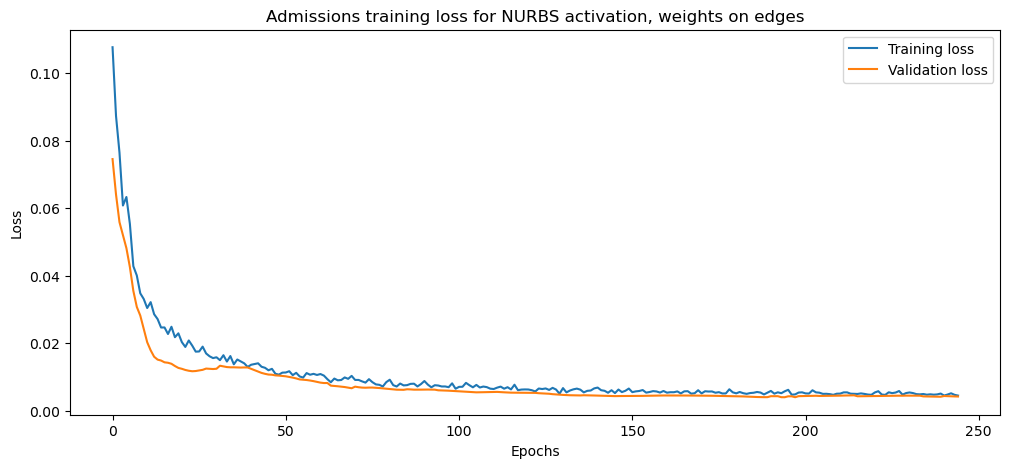

In [173]:
visualize_loss("Admissions training loss for NURBS activation, weights on edges", train_losses, val_losses)

### Evaluate on test set

Mean Absolute Error (MAE): 0.0539
Mean Squared Error (MSE): 0.0048
R² Score: 0.7663


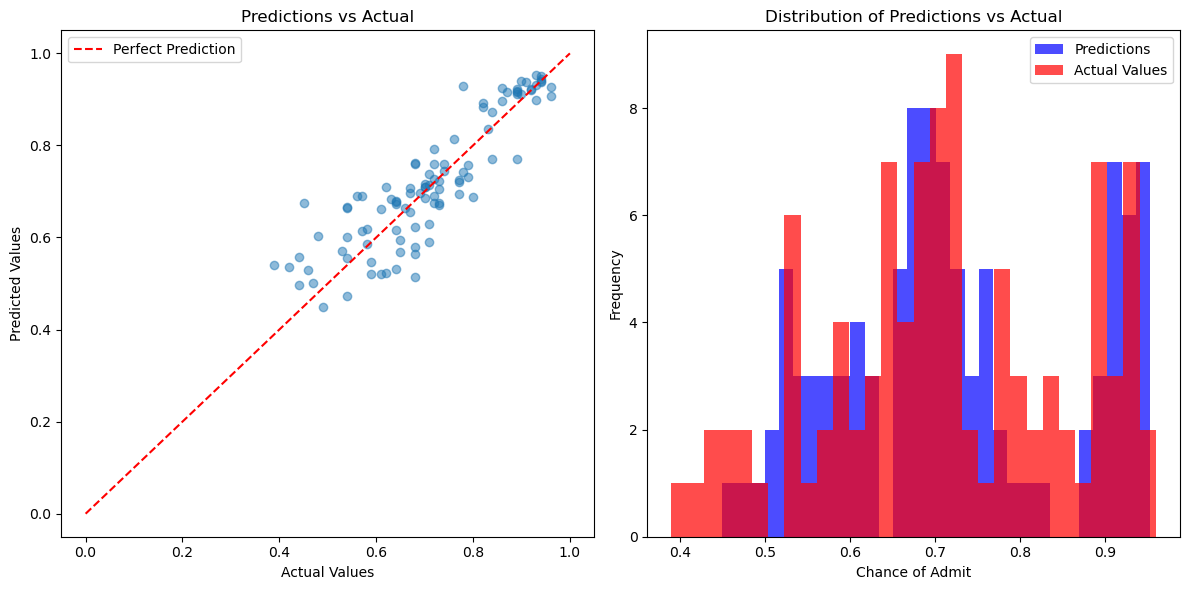

In [174]:
mae, mse, r2 = evaluate_model(tiny_nurbs_model, X_test_tensor, y_test_tensor)

In [175]:
new_row = pd.DataFrame([{
    'model_type': 'NURBS + edge weights',
    'train_time': exec_time,
    'test_mse': mse,
    'test_mae': mae,
    'test_r2': r2,
    'epochs': len(val_losses)
}])

edge_weight_summary = pd.concat([edge_weight_summary, new_row], ignore_index=True)

C:\Users\encip\AppData\Local\Temp\ipykernel_3552\1482124535.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  edge_weight_summary = pd.concat([edge_weight_summary, new_row], ignore_index=True)


In [176]:
edge_weight_summary

,model_type,train_time,test_mse,test_mae,test_r2,epochs
0,NURBS + edge weights,7.750526,0.00478,0.053887,0.766278,245


### Summarize parameter numbers

In [177]:
summary(tiny_nurbs_model, input_size=X_train_tensor.shape)

Layer (type:depth-idx)                   Output Shape              Param #
TinyNURBSNN                              [360, 1]                  --
├─Linear: 1-1                            [360, 16]                 128
├─NURBSActivationLayer: 1-2              [360, 16]                 320
├─Dropout: 1-3                           [360, 16]                 --
├─Linear: 1-4                            [360, 8]                  136
├─NURBSActivationLayer: 1-5              [360, 8]                  160
├─Dropout: 1-6                           [360, 8]                  --
├─Linear: 1-7                            [360, 1]                  9
├─Sigmoid: 1-8                           [360, 1]                  --
Total params: 753
Trainable params: 753
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.25
Input size (MB): 0.01
Forward/backward pass size (MB): 0.14
Params size (MB): 0.00
Estimated Total Size (MB): 0.15

### NURBS network of about 7-800 trainable parameters without edge weights in linear layers
Scale by adding more layers, therefore more NURBS activation function calls

In [178]:
class StrippedTinyNURBSNN(nn.Module):
    def __init__(self, input_size, degree, control_point_num):
        super(StrippedTinyNURBSNN, self).__init__()
        self.linear1 = nn.Linear(input_size, 16)
        self.linear2 = nn.Linear(16, 16)
        self.linear3 = nn.Linear(16, 8)
        self.linear4 = nn.Linear(8, 1)
        self.nurbs1 = NURBSActivationLayer(16, degree=degree, control_point_num=control_point_num)
        self.nurbs2 = NURBSActivationLayer(16, degree=degree, control_point_num=control_point_num)
        self.nurbs3 = NURBSActivationLayer(8, degree=degree, control_point_num=control_point_num)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.2)
        self.initialize_weights()

    def initialize_weights(self):
        with torch.no_grad():
            for layer in [self.linear1, self.linear2, self.linear3, self.linear4]:
                layer.weight = nn.Parameter(torch.ones_like(layer.weight), requires_grad=False)
                layer.bias = nn.Parameter(torch.zeros_like(layer.bias), requires_grad=False)

    def forward(self, x):
        x = self.linear1(x)
        x = self.nurbs1(x)
        x = self.linear2(x)
        x = self.nurbs2(x)
        x = self.dropout(x)
        x = self.linear3(x)
        x = self.nurbs3(x)
        x = self.dropout(x)
        x = self.linear4(x)
        x = self.sigmoid(x)
        return x

In [179]:
input_size = X_train_tensor.shape[1]
stripped_nurbs_model = StrippedTinyNURBSNN(input_size, degree = 3, control_point_num = 10)

In [180]:
# Optimizer
optimizer = optim.Adam(stripped_nurbs_model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

train_losses, val_losses, exec_time = train_model_with_validation(
    stripped_nurbs_model, 
    X_train_tensor, y_train_tensor,
    X_val_tensor, y_val_tensor,
    optimizer, loss_fn, 
    epochs = 1000, info_frequency = 50, patience = 50)

Epoch [50/1000] - Train Loss: 0.0306 - Val Loss: 0.0223
Epoch [100/1000] - Train Loss: 0.0230 - Val Loss: 0.0196
Epoch [150/1000] - Train Loss: 0.0152 - Val Loss: 0.0162
Early stopping triggered at epoch 169
Training completed in 6.83 seconds. Best Val Loss: 0.0135


### Visualize loss
No more high oscillation

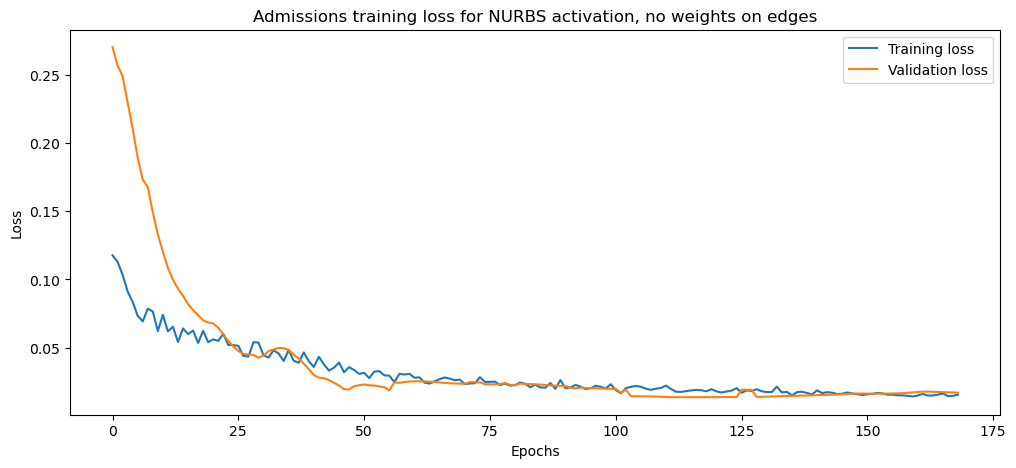

In [181]:
visualize_loss("Admissions training loss for NURBS activation, no weights on edges", train_losses, val_losses)

### Evaluate model

Mean Absolute Error (MAE): 0.0923
Mean Squared Error (MSE): 0.0152
R² Score: 0.2557


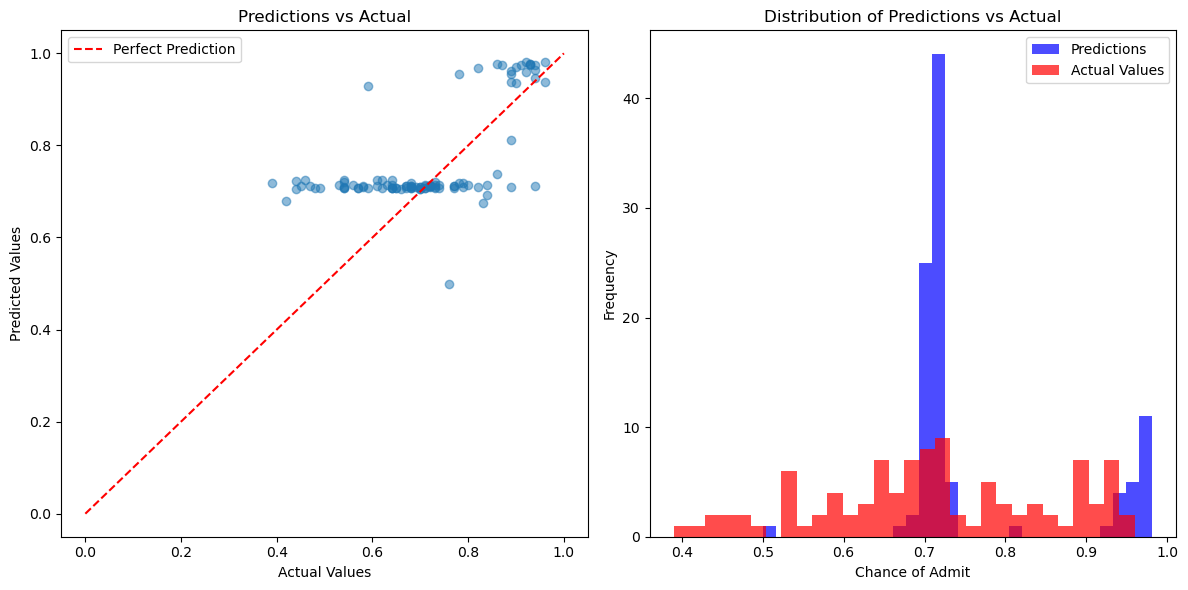

In [182]:
mae, mse, r2 = evaluate_model(stripped_nurbs_model, X_test_tensor, y_test_tensor)

In [183]:
new_row = pd.DataFrame([{
    'model_type': 'NURBS - edge weights (added layers)',
    'train_time': exec_time,
    'test_mse': mse,
    'test_mae': mae,
    'test_r2': r2,
    'epochs': len(val_losses)
}])

edge_weight_summary = pd.concat([edge_weight_summary, new_row], ignore_index=True)

In [184]:
edge_weight_summary

,model_type,train_time,test_mse,test_mae,test_r2,epochs
0,NURBS + edge weights,7.750526,0.004780,0.053887,0.766278,245
1,NURBS - edge weights (added layers),6.830127,0.015221,0.092278,0.255721,169


### Summarize parameter numbers

In [185]:
summary(stripped_nurbs_model, input_size=X_train_tensor.shape)

Layer (type:depth-idx)                   Output Shape              Param #
StrippedTinyNURBSNN                      [360, 1]                  --
├─Linear: 1-1                            [360, 16]                 (128)
├─NURBSActivationLayer: 1-2              [360, 16]                 320
├─Linear: 1-3                            [360, 16]                 (272)
├─NURBSActivationLayer: 1-4              [360, 16]                 320
├─Dropout: 1-5                           [360, 16]                 --
├─Linear: 1-6                            [360, 8]                  (136)
├─NURBSActivationLayer: 1-7              [360, 8]                  160
├─Dropout: 1-8                           [360, 8]                  --
├─Linear: 1-9                            [360, 1]                  (9)
├─Sigmoid: 1-10                          [360, 1]                  --
Total params: 1,345
Trainable params: 800
Non-trainable params: 545
Total mult-adds (Units.MEGABYTES): 2.27
Input size (MB): 0.01
Forward/back

### NURBS network of about 700-800 trainable parameters without edge weights in linear layers
Scale by adding more detail to the existing activation functions (increase control_point_num)

In [186]:
class StrippedTinyNURBSNN2(nn.Module):
    def __init__(self, input_size, degree, control_point_num):
        super(StrippedTinyNURBSNN2, self).__init__()
        self.linear1 = nn.Linear(input_size, 16)
        self.nurbs1 = NURBSActivationLayer(16, degree = degree, control_point_num = control_point_num)
        self.sigmoid = nn.Sigmoid()
        self.linear2 = nn.Linear(16, 8)
        self.nurbs2 = NURBSActivationLayer(8, degree = degree, control_point_num = control_point_num)
        self.linear3 = nn.Linear(8, 1)
        self.dropout = nn.Dropout(0.2)
        self.initialize_weights()

    def initialize_weights(self):
        with torch.no_grad():
            for layer in [self.linear1, self.linear2, self.linear3]:
                layer.weight = nn.Parameter(torch.ones_like(layer.weight), requires_grad=False)
                layer.bias = nn.Parameter(torch.zeros_like(layer.bias), requires_grad=False)

    def forward(self, x):
        x = self.linear1(x)
        x = self.nurbs1(x)
        x = self.dropout(x)
        x = self.linear2(x)
        x = self.nurbs2(x)
        x = self.dropout(x)
        x = self.linear3(x)
        x = self.sigmoid(x)
        return x

In [187]:
input_size = X_train_tensor.shape[1]
stripped_nurbs_model2 = StrippedTinyNURBSNN2(input_size, degree = 3, control_point_num = 16)

In [188]:
# Optimizer
optimizer = optim.Adam(stripped_nurbs_model2.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

train_losses, val_losses, exec_time = train_model_with_validation(
    stripped_nurbs_model2, 
    X_train_tensor, y_train_tensor,
    X_val_tensor, y_val_tensor,
    optimizer, loss_fn, 
    epochs = 1000, info_frequency = 50, patience = 50)

Epoch [50/1000] - Train Loss: 0.0457 - Val Loss: 0.0287
Epoch [100/1000] - Train Loss: 0.0322 - Val Loss: 0.0096
Epoch [150/1000] - Train Loss: 0.0222 - Val Loss: 0.0079
Epoch [200/1000] - Train Loss: 0.0165 - Val Loss: 0.0069
Early stopping triggered at epoch 215
Training completed in 8.09 seconds. Best Val Loss: 0.0065


### Visualize loss
Minimal oscillation can be observed both in validation loss (compared to previous case), but the gap between training and validation loss is more considerable

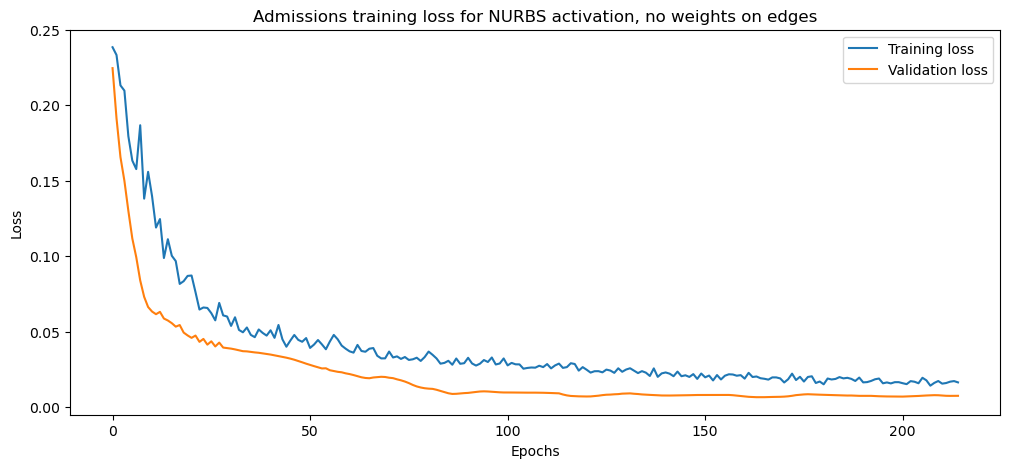

In [189]:
visualize_loss("Admissions training loss for NURBS activation, no weights on edges", train_losses, val_losses)

### Evaluate

Mean Absolute Error (MAE): 0.0803
Mean Squared Error (MSE): 0.0113
R² Score: 0.4487


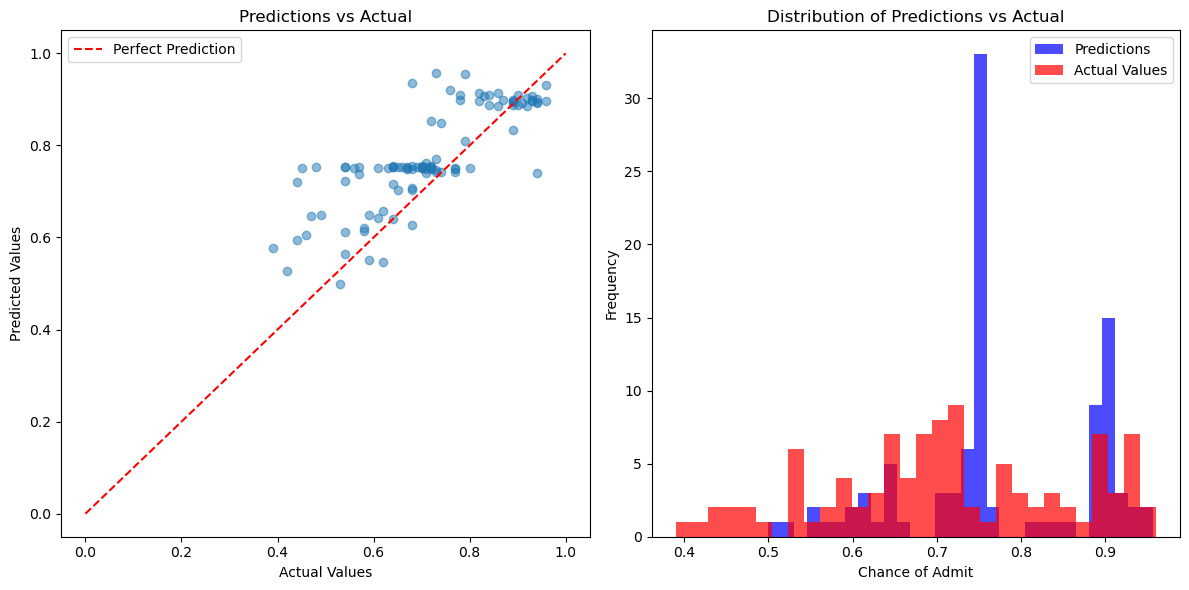

In [190]:
mae, mse, r2 = evaluate_model(stripped_nurbs_model2, X_test_tensor, y_test_tensor)

In [191]:
new_row = pd.DataFrame([{
    'model_type': 'NURBS - edge weights (added control points)',
    'train_time': exec_time,
    'test_mse': mse,
    'test_mae': mae,
    'test_r2': r2,
    'epochs': len(val_losses)
}])

edge_weight_summary = pd.concat([edge_weight_summary, new_row], ignore_index=True)

In [192]:
summary(stripped_nurbs_model2, input_size=X_train_tensor.shape)

Layer (type:depth-idx)                   Output Shape              Param #
StrippedTinyNURBSNN2                     [360, 1]                  --
├─Linear: 1-1                            [360, 16]                 (128)
├─NURBSActivationLayer: 1-2              [360, 16]                 512
├─Dropout: 1-3                           [360, 16]                 --
├─Linear: 1-4                            [360, 8]                  (136)
├─NURBSActivationLayer: 1-5              [360, 8]                  256
├─Dropout: 1-6                           [360, 8]                  --
├─Linear: 1-7                            [360, 1]                  (9)
├─Sigmoid: 1-8                           [360, 1]                  --
Total params: 1,041
Trainable params: 768
Non-trainable params: 273
Total mult-adds (Units.MEGABYTES): 1.94
Input size (MB): 0.01
Forward/backward pass size (MB): 0.14
Params size (MB): 0.00
Estimated Total Size (MB): 0.16

In [193]:
edge_weight_summary

,model_type,train_time,test_mse,test_mae,test_r2,epochs
0,NURBS + edge weights,7.750526,0.004780,0.053887,0.766278,245
1,NURBS - edge weights (added layers),6.830127,0.015221,0.092278,0.255721,169
2,NURBS - edge weights (added control points),8.090295,0.011274,0.080323,0.448722,215


### <span style="color: green;">Conclusions</span>
- Compared to the per-layer-parametrisation of the NURBS curve, a more considerable difference can be observed between the with-weights and no-weights results.
- The edge weights seem to help a lot, their inclusion generally resulting in a lower loss and higher $R^2$ value than the experiments without edge weights.
- The added control points variant of the no-weights network sometimes produces fairly good results, but other times remains closer to a test loss of around 0.01.
- In all 3 cases, the trainable parameter count of the network remains between 750 and 800, as evidenced by the summaries printed out.
- The architectures above without edge weights provides dissatisfactory results
  - E. g. negative $R^2$ values indicate that a model is worse than a dummy model that always predicts the sample mean
  - Experiments with larger networks and/or different regression problems may be beneficial
- In this specific example, training times remain similar, independent of the presence of edge weights, since the no-weights versions generally run for fewer epochs before they seem to overfit

## Comparison for classification in concentric circles

In [13]:
from sklearn.datasets import make_circles

def load_circles_data(noise=0.1):
    # Generate the data
    X, y = make_circles(n_samples=1000, factor=0.5, noise=noise, random_state=SEED)

    # Standardize the inputs
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Convert to PyTorch tensors
    X_tensor = torch.tensor(X, dtype=torch.float32)
    y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # Shape (N, 1)

    return X_tensor, y_tensor

X_circles, y_circles = load_circles_data(0.15)

### ReLU

In [36]:
class CircleReluNN(nn.Module):
    def __init__(self):
        super(CircleReluNN, self).__init__()
        self.linear1 = nn.Linear(input_size, 2)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(2, 1)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        # x = self.dropout(x)
        x = self.linear2(x)
        x = self.sigmoid(x)
        return x

In [37]:
input_size = X_circles.shape[1]
circle_relu_model = CircleReluNN()

In [38]:
# Optimizer
optimizer = optim.Adam(circle_relu_model.parameters(), lr=0.01)
loss_fn = nn.BCELoss()

train_losses = train_model(
    circle_relu_model, 
    X_circles, y_circles,
    optimizer, loss_fn, 
    epochs = 500, info_frequency = 50)

Epoch [50/500], Loss: 0.6607
Epoch [100/500], Loss: 0.6255
Epoch [150/500], Loss: 0.5807
Epoch [200/500], Loss: 0.5593
Epoch [250/500], Loss: 0.5513
Epoch [300/500], Loss: 0.5481
Epoch [350/500], Loss: 0.5463
Epoch [400/500], Loss: 0.5452
Epoch [450/500], Loss: 0.5446
Epoch [500/500], Loss: 0.5442


In [39]:
@torch.no_grad()
def plot_decision_boundary(model, X, y, title="Decision Boundary", fig_name = 'fig.jpg'):
    model.eval()

    # Create a grid of points
    h = 0.01
    x_min, x_max = -2, 2
    y_min, y_max = -2, 2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    grid = np.c_[xx.ravel(), yy.ravel()]

    grid_tensor = torch.tensor(grid, dtype=torch.float32)

    # Get model predictions
    preds = model(grid_tensor).numpy()
    preds = preds.reshape(xx.shape)

    # Plotting
    plt.figure(figsize=(6, 6))
    plt.contourf(xx, yy, preds, levels=[0, 0.5, 1], cmap=plt.cm.coolwarm, alpha=0.6)
    plt.contour(xx, yy, preds, levels=[0.5], colors='black')
    y_np = y.numpy().flatten()
    plt.scatter(X[y_np == 0, 0],X[y_np == 0, 1], color='blue', edgecolor='k', label='Class 0')
    plt.scatter(X[y_np == 1, 0], X[y_np == 1, 1], color='red', edgecolor='k', label='Class 1')
    plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.grid(True)
    fig_path = Path("figures") / fig_name
    plt.savefig(fig_path)
    plt.show()

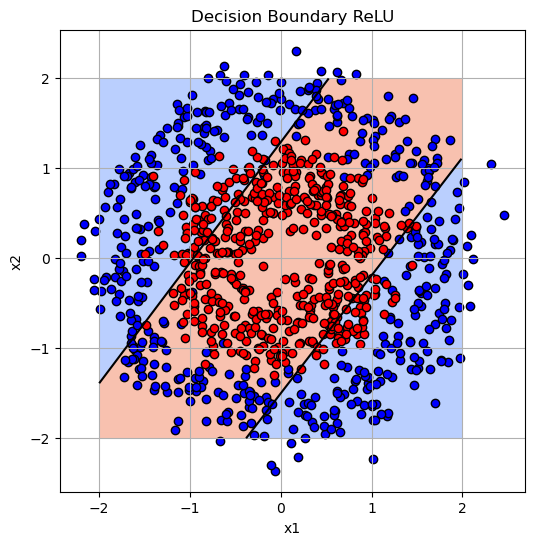

In [40]:
plot_decision_boundary(circle_relu_model,X_circles, y_circles, title="Decision Boundary ReLU", fig_name="db_relu.jpg")

### B-spline

In [24]:
class CircleBSplineNN(nn.Module):
    def __init__(self, input_size, degree, control_point_num):
        super(CircleBSplineNN, self).__init__()
        self.linear1 = nn.Linear(input_size, 2)
        self.bspline = BSplineActivationLayer(2, 3, 10)
        self.linear2 = nn.Linear(2, 1)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.linear1(x)
        x = self.bspline(x)
        # x = self.dropout(x)
        x = self.linear2(x)
        x = self.sigmoid(x)
        return x

In [25]:
input_size = X_circles.shape[1]
circle_bspline_model = CircleBSplineNN(input_size, 3, 10)

In [26]:
# Optimizer
optimizer = optim.Adam(circle_bspline_model.parameters(), lr=0.01)
loss_fn = nn.BCELoss()

train_losses = train_model(
    circle_bspline_model, 
    X_circles, y_circles,
    optimizer, loss_fn, 
    epochs = 500, info_frequency = 50)

Epoch [50/500], Loss: 0.6628
Epoch [100/500], Loss: 0.5194
Epoch [150/500], Loss: 0.2907
Epoch [200/500], Loss: 0.1810
Epoch [250/500], Loss: 0.1441
Epoch [300/500], Loss: 0.1286
Epoch [350/500], Loss: 0.1210
Epoch [400/500], Loss: 0.1168
Epoch [450/500], Loss: 0.1144
Epoch [500/500], Loss: 0.1129


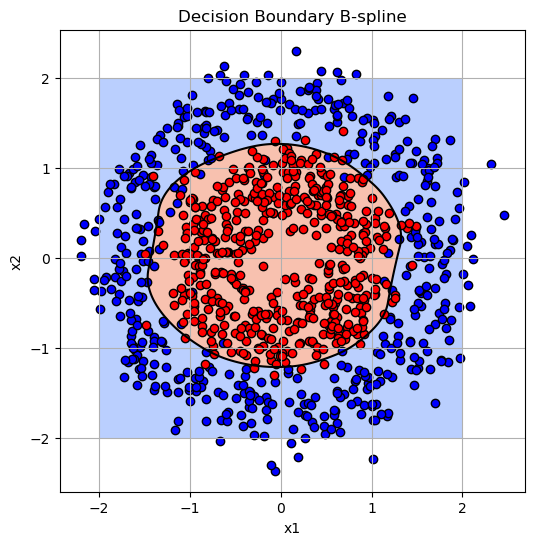

In [27]:
plot_decision_boundary(circle_bspline_model,X_circles, y_circles, title="Decision Boundary B-spline", fig_name="db_bspline.jpg")

### NURBS

In [28]:
class CircleNURBSNN(nn.Module):
    def __init__(self, input_size, degree, control_point_num):
        super(CircleNURBSNN, self).__init__()
        self.linear1 = nn.Linear(input_size, 2)
        self.nurbs = NURBSActivationLayer(2, 3, 10)
        self.linear2 = nn.Linear(2, 1)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.linear1(x)
        x = self.nurbs(x)
        # x = self.dropout(x)
        x = self.linear2(x)
        x = self.sigmoid(x)
        return x

In [29]:
input_size = X_circles.shape[1]
circle_nurbs_model = CircleNURBSNN(input_size, 3, 10)

In [30]:
# Optimizer
optimizer = optim.Adam(circle_nurbs_model.parameters(), lr=0.01)
loss_fn = nn.BCELoss()

train_losses = train_model(
    circle_nurbs_model, 
    X_circles, y_circles,
    optimizer, loss_fn, 
    epochs = 500, info_frequency = 50)

Epoch [50/500], Loss: 0.5746
Epoch [100/500], Loss: 0.2942
Epoch [150/500], Loss: 0.4891
Epoch [200/500], Loss: 0.1605
Epoch [250/500], Loss: 0.4412
Epoch [300/500], Loss: 0.2523
Epoch [350/500], Loss: 0.2685
Epoch [400/500], Loss: 0.3430
Epoch [450/500], Loss: 0.3385
Epoch [500/500], Loss: 0.3492


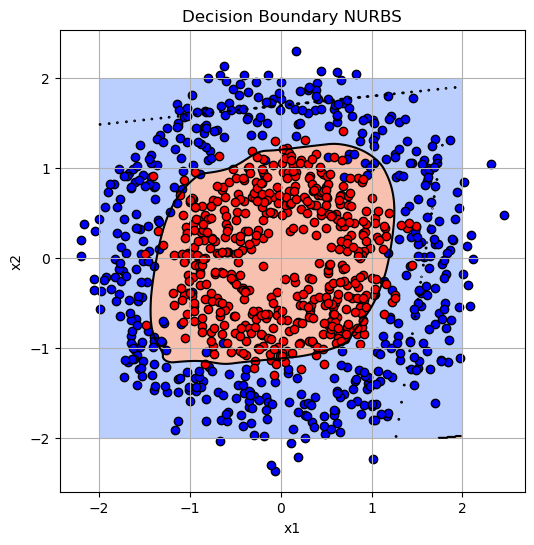

In [31]:
plot_decision_boundary(circle_nurbs_model,X_circles, y_circles, title="Decision Boundary NURBS", fig_name="db_nurbs.jpg")

## Remains to be seen

* Should knots be uniformly distributed or something else?
* How to initialize activation curve parameters?
    * For now, torch.randn is used in most cases, so there is random sampling from a normal distribution
    * For NURBS, B-spline type initialization seems to yield the best results (random points, uniformly 1 weights)
* Performance in a more complex task e.g. image classification after CNN and flattening